# EEG Preprocessing

# Generate Cleaned Epochs

Our preprocessing pipeline takes our initial raw data and makes fully cleaned epochs data. For the MSIT task, we have two events of interest, stimulus presentation and response, that we time-lock to in order to create two separate sets of epochs.

The full preprocessing pipeline to create the clean epochs consists of the following steps:
1. Exclude Bad Channels
2. Remove EOG and ECG Artifact with ICA
3. Bandpass filter the data to remove high frequency noise (motor, line, etc.) and low frequency drift (sweat, etc.)
4. Time-lock to stimulus and response events to create two sets of epochs. We exclude non-response trials from both.
5. Use autoreject to automatically exclude bad epochs and interpolate bad channel segments per epoch.
6. Average re-reference the data to remove global noise due to noise in the reference channel.
7. Surface laplacian the cleaned epochs to get spatially localized epochs for future analysis.

The first few cells below pre-compute certain parts of the pipeline that require lots of processing (fitting ICA, autoreject) and require manual interaction (marking bad channels, verifying ICA components). The final cell then takes all of the cached outputs of the previous cells and runs all of the steps listed above to generate cleaned epochs both with and without the surface laplacian transform.

## Mark Bad Channels

The first step in our preprocessing pipeline is to mark bad and dead channels. There are various reasons that channels could be outright bad:
- The channel is dead on the cap
- The fit of the cap prevented the channel from maintaining contact with the scalp
- The channel was not prepared adequately or could not be prepared adequately

We mark bad channels manually by using MNE's interactive Raw plotting tool that allows one to mark bad channels while visualizing them. These bad channels then get saved out to a text file so we can access them later. Getting rid of outright bad channels help our ICA in the next step fit better and also helps autoreject perform better as well.

In [1]:
import os
import sys
sys.path.append('../src')
from preprocessing import mark_bad_channels
from utils import select_subjects
import pandas as pd
import json

%matplotlib

deriv_dir = '../data/derivatives/eeg_preprocessing'
if not os.path.exists(deriv_dir):
    os.makedirs(deriv_dir)

# load behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')
behavior = behavior[behavior.modality == 'eeg']
    
# load config parameters
config = json.load(open('experiment_config.json', 'r'))

subjects = select_subjects('eeg', exclude=[])
for subject in subjects:
    print(subject)
    
    # create the subject directory
    sub_dir = '%s/%s' % (deriv_dir, subject)
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)
    sub_behavior = behavior[behavior.participant_id == subject]
    
    # raw and bad channel filepaths
    raw_file = '../data/%s/eeg/%s_task-msit_eeg_raw.fif' % (subject, subject)
    bad_ch_file = '%s/%s_task-msit_badchs.txt' % (sub_dir, subject)
    
    # iteratively mark bad channels and check until satisfied 
    raw = mark_bad_channels(raw_file, bad_ch_file, config, sub_behavior)
    
    # write the updated bad channels out to file
    with open(bad_ch_file, 'w') as fid:
        for bad in raw.info['bads']:
            fid.write('%s\n' % bad)

print('Done!')

Using matplotlib backend: Qt4Agg
sub-hc012
sub-hc035
sub-hc031
Done!


## ICA

The next step in our preprocessing pipeline is to use Independent Components Analysis to subtract components related to eye movements and heartbeat from the data. We first fit the ICA to each subject's data and automatically extract out components highly correlated with EOG and ECG events. Then we manually QC the extracted components to make sure we remove the minimal set that removes EOG and ECG activity.

Throughout this process we make heavy use of MNE's ICA tools: https://martinos.org/mne/stable/auto_tutorials/plot_artifacts_correction_ica.html


### Fit the ICA

First, we fit the ICA to each subject's raw data. Prior to doing so, we remove bad channels and highpass the data with a 1 Hz highpass to help with extracting the desired components.

After fitting the ICA, we use MNE's algorithms to automatically mark components that it thinks are EOG and/or ECG related. This is done using a correlation procedure with the EOG and ECG auxiliary channels.

In [1]:
import json
import sys
sys.path.append('../src')
from preprocessing import fit_ica 
from utils import select_subjects
from mne.io import Raw
from mne import set_log_level
import os

set_log_level('critical')

deriv_dir = '../data/derivatives/eeg_preprocessing'
    
# load config parameters
config = json.load(open('experiment_config.json', 'r'))

subjects = select_subjects('eeg', exclude=[])
for subject in subjects:
    print(subject)
    
    # data filepaths
    raw_file = '../data/%s/eeg/%s_task-msit_eeg_raw.fif' % (subject, subject)
    bad_ch_file = '%s/%s/%s_task-msit_badchs.txt' % (deriv_dir, subject, subject)
    ica_file = '%s/%s/%s_task-msit-ica.fif' % (deriv_dir, subject, subject)
    
    # load raw, mark bad channels
    raw = Raw(raw_file, preload=True, verbose=False)
    raw.load_bad_channels(bad_ch_file)
    
    ica = fit_ica(raw, config['aux_chs'])
    ica.save(ica_file)
    
print('Done!')

sub-hc012
sub-hc035
sub-hc031
Done!


## Verify ICA

Now we visualize the result and manually update the ICA components for exclusion. This is necessary because MNE's auto-detection tends to be overly aggressive and we want to remove the minimal amount of components so we don't risk removing actual data.

I used the following philosophy to determine the final bad components: Remove the minimal subset of components necessary to remove EOG and ECG activity from the data while ensuring that each component removed has a spatial topography indicative of EOG and ECG activity only.

To facilitate this process, the following cell repeatedly plots the following:
  - Makes an interactive plot of the ICA components. Bad components can be updated by clicking on the component time courses. Component spatial topographies can be seen by clicking on the component channel name.
  - Plots the epoched data before and after ICA time-locked to the task events to see how well EOG and ECG artifact has been removed from the task-locked data.
  - Plots component time courses time-locked to EOG and ECG components to see how well each component captures those artifacts
  - Plots the data before and after ICA time-locked to EOG and ECG components to see how well this artifact has been removed from the data at large.
  
After closing all of these plots, a dialog box pops up asking if you want to move on. Entering 'n' will repeat the above process with all of the plots using the newly updated components. Entering 'y' moves on to the next subject. One should enter 'n' until confident they have found the appropriate set of components to remove.

In [2]:
import os
import json
import sys
sys.path.append('../src')
from preprocessing import verify_ica 
from utils import select_subjects
import pandas as pd
import matplotlib.pyplot as plt
from mne.io import Raw
from mne.preprocessing import read_ica
from mne import set_log_level

set_log_level('critical')

%matplotlib

deriv_dir = '../data/derivatives/eeg_preprocessing'
    
# load config parameters
config = json.load(open('experiment_config.json', 'r'))

# load behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')
behavior = behavior[behavior.modality == 'eeg']


subjects = select_subjects('eeg', exclude=[])
for subject in subjects:
    print(subject)
    sub_behavior = behavior[behavior.participant_id == subject]
    
    # data filepaths
    raw_file = '../data/%s/eeg/%s_task-msit_eeg_raw.fif' % (subject, subject)
    bad_ch_file = '%s/%s/%s_task-msit_badchs.txt' % (deriv_dir, subject, subject)
    ica_file = '%s/%s/%s_task-msit-ica.fif' % (deriv_dir, subject, subject)
    
    # load raw, mark bad channels
    raw = Raw(raw_file, preload=True, verbose=False)
    raw.load_bad_channels(bad_ch_file)
    
    # load ica
    ica = read_ica(ica_file)
    
    # iteratively update valid bad components
    ok = 'n'
    while ok != 'y':
        
        ica = verify_ica(ica, raw, sub_behavior, config)
        
        ok = raw_input('Ok to move on? (y or n):')
    
    # save updated ica
    ica.save(ica_file)
    
print('Done!')

Using matplotlib backend: Qt4Agg
sub-hc012
sub-hc035
sub-hc031
Done!


## Mark and Interpolate Bad Epochs with Autoreject

The next step in our pipeline is to fit to our data. Autoreject is a software package for automatically interpolating and rejecting bad epochs in our data. It works by estimating an amplitude rejection threshold for each channel in our data. It then estimates number of channels to interpolate for each epoch as well as a percentage of channels that have to be bad on an epoch in order to throw out that epoch. Using these parameters, it then labels every epoch as either bad or good. For good epochs, it interpolates however many bad channels it determined should be interpolated for any given epoch. More information can be found on the autoreject website: https://autoreject.github.io/

The below cell fits autoreject to our Epochs data after first excluding bad channels, removing bad ICA components, and bandpass filtering the data. The fitted autoreject object is then pickled and a summary plot for each epoch type is also saved out.

In [1]:
import json
import sys
sys.path.append('../src')
from preprocessing import plot_autoreject_summary, construct_epochs
from utils import select_subjects
from autoreject import LocalAutoRejectCV, compute_thresholds
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
from mne.io import Raw
from mne.preprocessing import read_ica
from mne import set_log_level
import pickle

set_log_level('critical')

deriv_dir = '../data/derivatives/eeg_preprocessing'
    
# load config parameters
config = json.load(open('experiment_config.json', 'r'))

# load behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')
behavior = behavior[behavior.modality == 'eeg']

# parallelize and seed autoreject threshold function
thresh_func = partial(compute_thresholds, random_state=42, n_jobs=5)

subjects = select_subjects('eeg', exclude=[])
for subject in subjects:
    print(subject)
    sub_behavior = behavior[behavior.participant_id == subject]
    
    # data filepaths
    raw_file = '../data/%s/eeg/%s_task-msit_eeg_raw.fif' % (subject, subject)
    bad_ch_file = '%s/%s/%s_task-msit_badchs.txt' % (deriv_dir, subject, subject)
    ica_file = '%s/%s/%s_task-msit-ica.fif' % (deriv_dir, subject, subject)
    
    # load raw, mark bad channels
    raw = Raw(raw_file, preload=True, verbose=False)
    raw.load_bad_channels(bad_ch_file)
    
    # load ica and apply
    ica = read_ica(ica_file)
    ica.apply(raw, exclude=ica.exclude)
    
    # bandpass filter
    raw.filter(l_freq=config['filter_highpass'],
               h_freq=config['filter_lowpass'])
    
    # iterate through epoch types for autoreject fitting
    epochs = construct_epochs(raw, config['epochs_info'], sub_behavior)
    for epo_type in config['epochs_info']['epo_types']:
        print(epo_type)
        
        # fit autoreject
        ar = LocalAutoRejectCV(consensus_percs=config['consensus_percs'],
                               n_interpolates=config['n_interpolates'],
                               thresh_func=thresh_func, verbose=False)
        ar.fit(epochs[epo_type])
        
        # save autoreject fit out to file
        ar_file = '%s/%s/%s_task-msit_%s_ar.pkl' % (deriv_dir, subject, 
                                                    subject, epo_type)
        with open(ar_file, 'w') as output:
            pickle.dump(ar, output, pickle.HIGHEST_PROTOCOL)
        
        # plot autoreject summary
        fig = plot_autoreject_summary(ar, subject, epo_type,
                                      epochs[epo_type].ch_names)
        fig.savefig(ar_file.replace('.pkl', '_summary.png'))
        plt.close(fig)
        
print('Done!')

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


sub-hc012
stimulus
response
sub-hc035
stimulus
response
sub-hc031
stimulus
response
Done!


## Run All the Preprocessing Steps

With all of the intermediate steps completed from the cells above, one can run this cell which takes in each subject's raw and runs all of the preprocessing steps listed above to generate clean epochs both with and without surface laplacian transform. A summary plot for each subject is also written out showing evoked data in a butterfly plot after each preprocessing step from the original data to the final cleaned data in succession.

sub-hc012
sub-hc035
sub-hc031
Done!


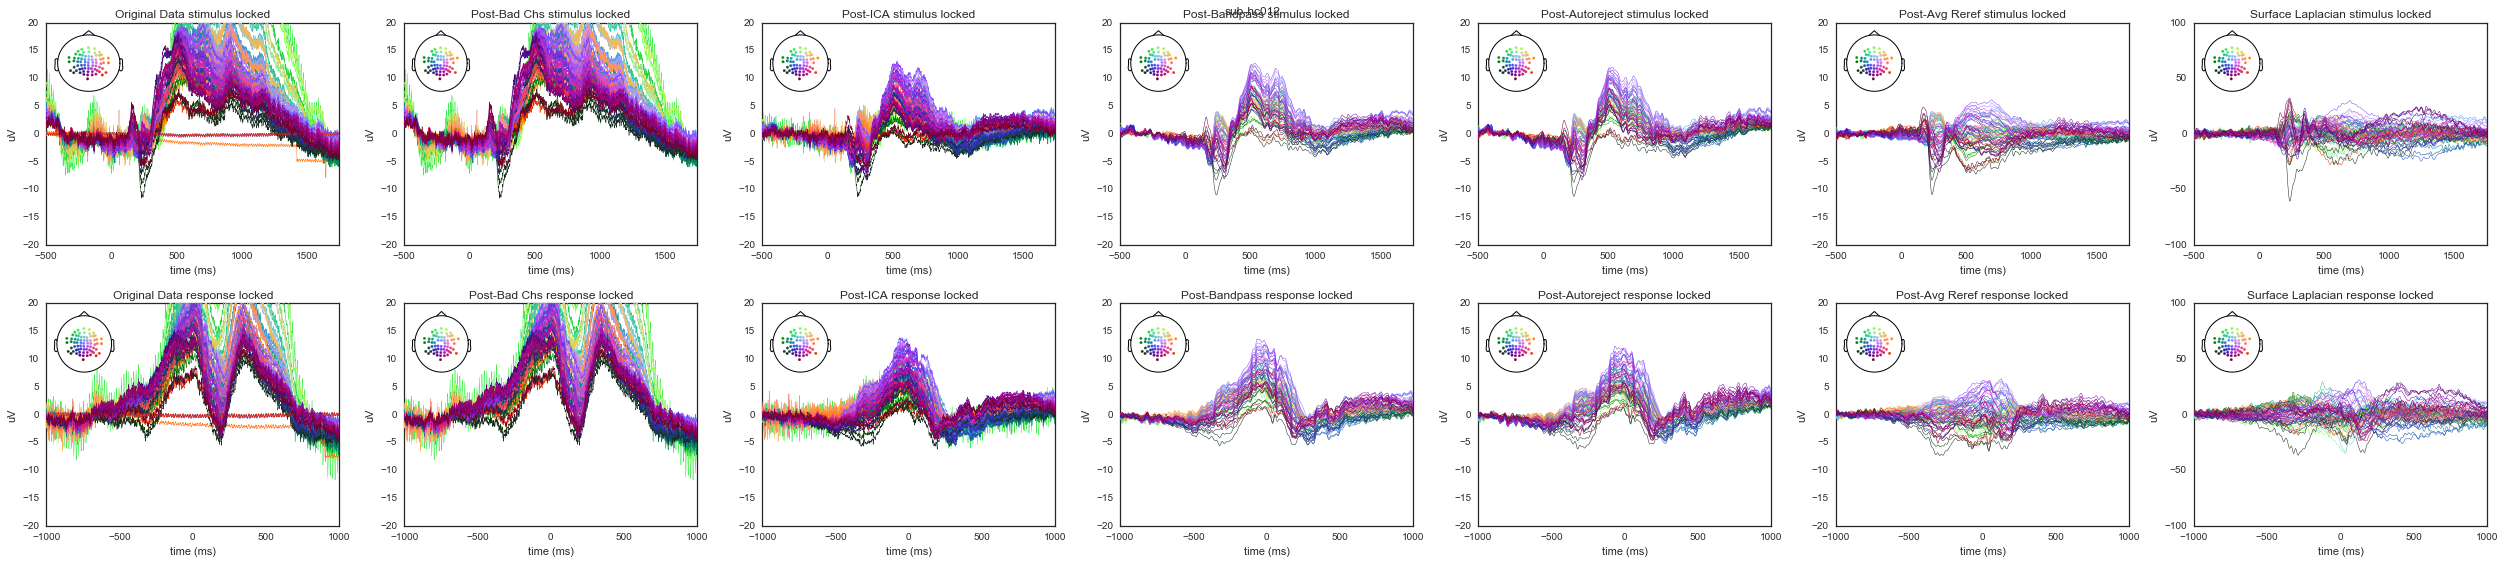

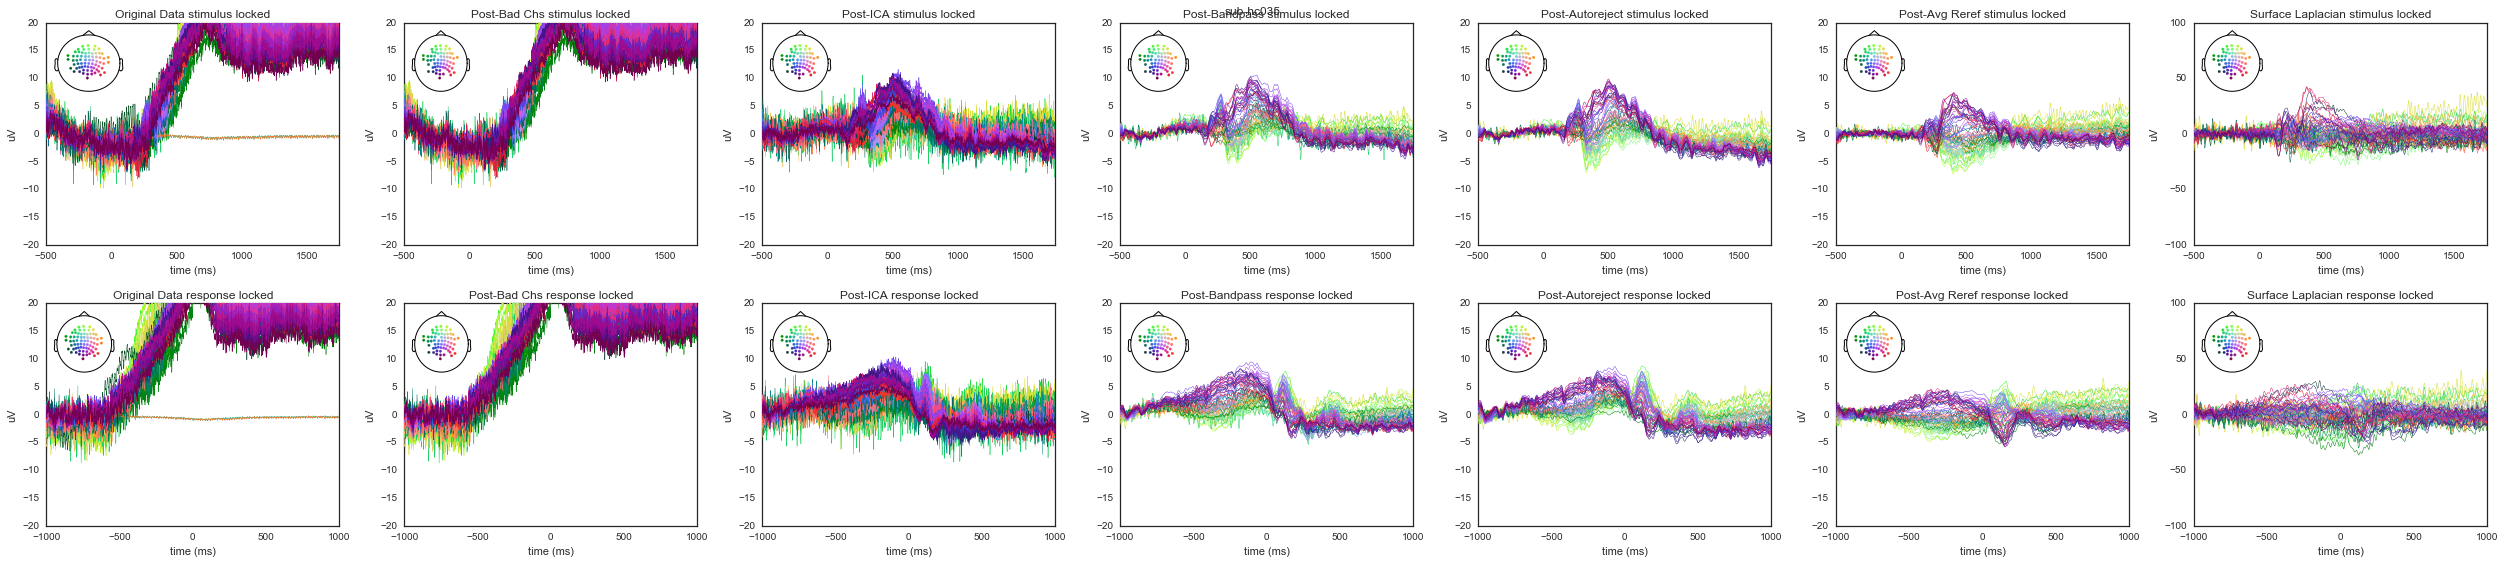

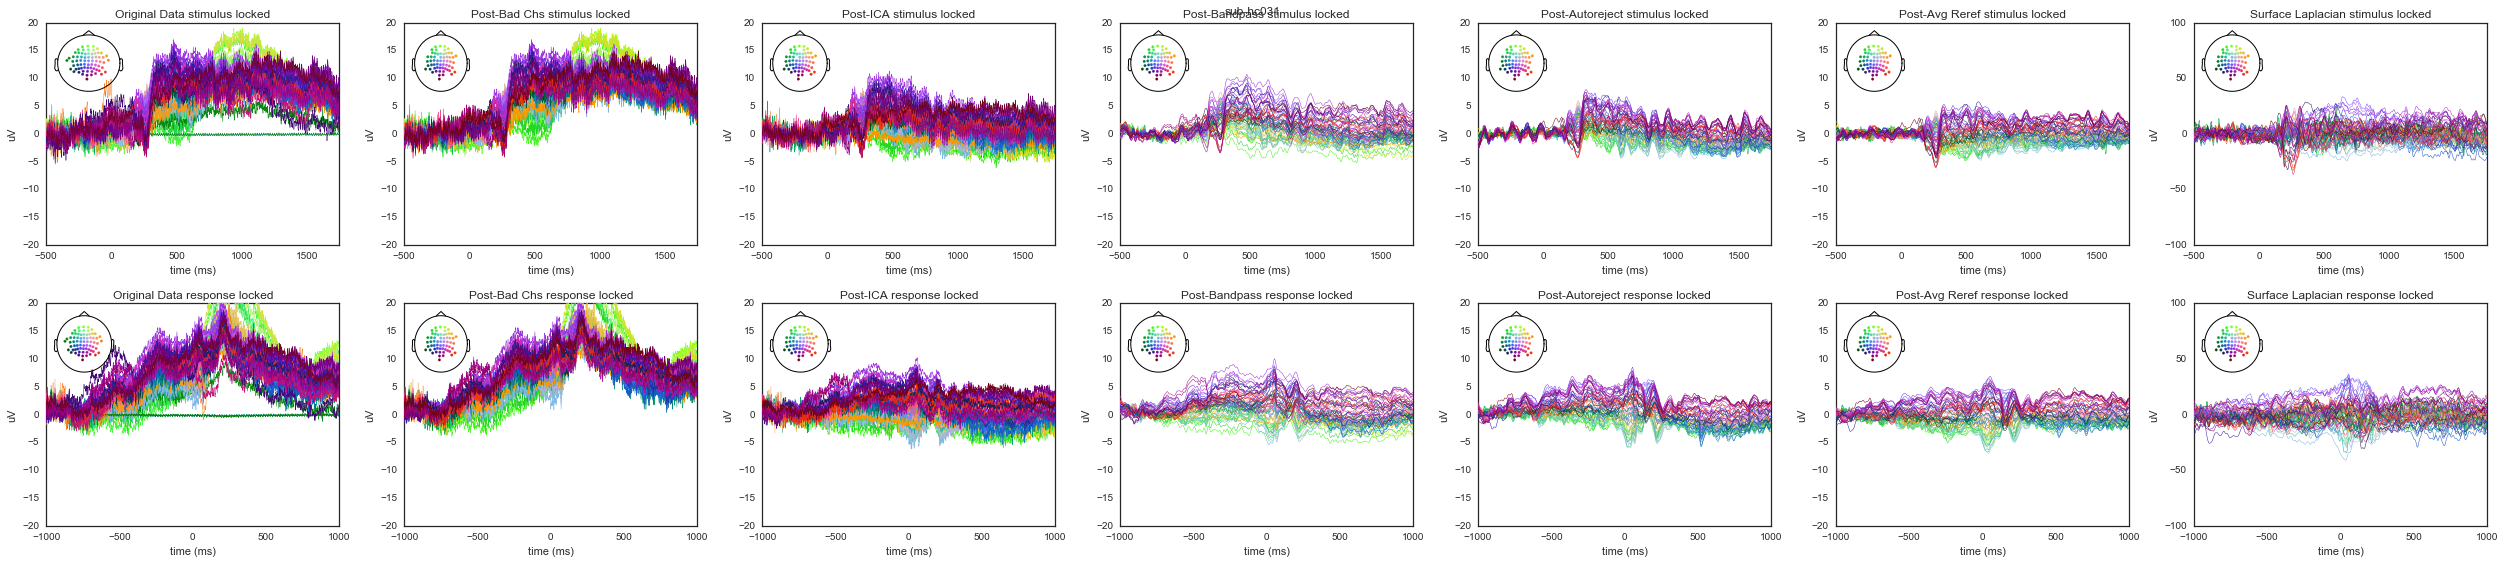

In [7]:
import json
import pickle
import sys
sys.path.append('../src')
from preprocessing import plot_butterfly, construct_epochs
from utils import select_subjects
from surface_laplacian import surface_laplacian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.io import Raw
from mne.preprocessing import read_ica
from mne import set_log_level
import os

set_log_level('critical')

deriv_dir = '../data/derivatives/eeg_preprocessing'
    
# load config parameters
config = json.load(open('experiment_config.json', 'r'))

# load behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')
behavior = behavior[behavior.modality == 'eeg']

# load spherical coordinates for surface laplacian
coord_file = '../data/eeg_spherical_coordinates.txt'
coords = pd.read_csv(coord_file, names=['num', 'ch', 'x', 'y', 'z'], sep=',')
x, y, z = np.array(coords.x), np.array(coords.y), np.array(coords.z)

subjects = select_subjects('eeg', exclude=[])
subjects = ['sub-hc012', 'sub-hc035', 'sub-hc031']
for subject in subjects:
    print(subject)
    sub_behavior = behavior[behavior.participant_id == subject]
    
    # data filepaths
    raw_file = '../data/%s/eeg/%s_task-msit_eeg_raw.fif' % (subject, subject)
    bad_ch_file = '%s/%s/%s_task-msit_badchs.txt' % (deriv_dir, subject, subject)
    ica_file = '%s/%s/%s_task-msit-ica.fif' % (deriv_dir, subject, subject)
    
    # create summary figure
    fig, axs = plt.subplots(2, 7, figsize=(35, 8))
    
    # load original raw
    raw = Raw(raw_file, preload=True, verbose=False)
    epochs = construct_epochs(raw, config['epochs_info'], sub_behavior) 
    plot_butterfly(epochs, title='Original Data', axs=axs[:, 0], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1])
    
    # mark bad channels
    raw.load_bad_channels(bad_ch_file)
    epochs = construct_epochs(raw, config['epochs_info'], sub_behavior) 
    plot_butterfly(epochs, title='Post-Bad Chs', axs=axs[:, 1], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1])
    
    # load ica and apply
    ica = read_ica(ica_file)
    ica.apply(raw, exclude=ica.exclude)
    epochs = construct_epochs(raw, config['epochs_info'], sub_behavior) 
    plot_butterfly(epochs, title='Post-ICA', axs=axs[:, 2], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1])
    
    # bandpass filter
    raw.filter(l_freq=config['filter_highpass'],
               h_freq=config['filter_lowpass'])
    epochs = construct_epochs(raw, config['epochs_info'], sub_behavior) 
    plot_butterfly(epochs, title='Post-Bandpass', axs=axs[:, 3], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1])
    
    # load autoreject and transform epochs 
    for epo_type in epochs.keys():
        ar_file = '%s/%s/%s_task-msit_%s_ar.pkl' % (deriv_dir, subject,
                                                    subject, epo_type)
        ar = pickle.load(open(ar_file, 'r'))
        epochs[epo_type] = ar.transform(epochs[epo_type])
    plot_butterfly(epochs, title='Post-Autoreject', axs=axs[:, 4], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1])
    
    # average re-reference and save out cleaned epochs
    for epo_type in epochs.keys():
        f = '%s/%s/%s_task-msit_%s-epo.fif'
        epochs[epo_type].set_eeg_reference()
        epochs[epo_type].save(f % (deriv_dir, subject, subject, epo_type))
    plot_butterfly(epochs, title='Post-Avg Reref', axs=axs[:, 5], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1], h_freq=None,
                   l_freq=None)
    
    # surface laplacian transform and save
    lap_epochs = {}
    for epo_type in epochs.keys():
        f = '%s/%s/%s_task-msit_%s_laplacian-epo.fif'
        lap_epochs[epo_type] = surface_laplacian(epochs[epo_type],
                                                 x, y, z, 'epochs')
        lap_epochs[epo_type].save(f % (deriv_dir, subject, subject, epo_type))
        
    plot_butterfly(lap_epochs, title='Surface Laplacian', axs=axs[:, 6], 
                   tmins=[-.5, -1], tmaxs=[1.75, 1], h_freq=None,
                   l_freq=None, ylim=(-100, 100))
        
    # save summary figure 
    fig.suptitle(subject)
    fig.savefig('%s/%s/%s_preproc_visual_summary.png' % (deriv_dir,
                                                         subject,
                                                         subject))
    
        
print('Done!')

# Group Summaries & Subject Exclusions

With our cleaned epochs data generated, the next step is to use the individual summary plots and group summary plots to determine any subjects who should be excluded. The following sections first produce summary plots at the group level and then in the final section we exclude subjects whose data was determined grounds for exclusion.

## Bad Channel Group Summary

This cell plots a group summary of bad channels. It shows which channels were marked bad for which subjects via a heatmap. It also plots the percentage of bad channels marked by subject as well as the percentage of subjects who had a particular channel marked bad so we can see both the subjects with the most bad channels and the channels that were the least reliable.

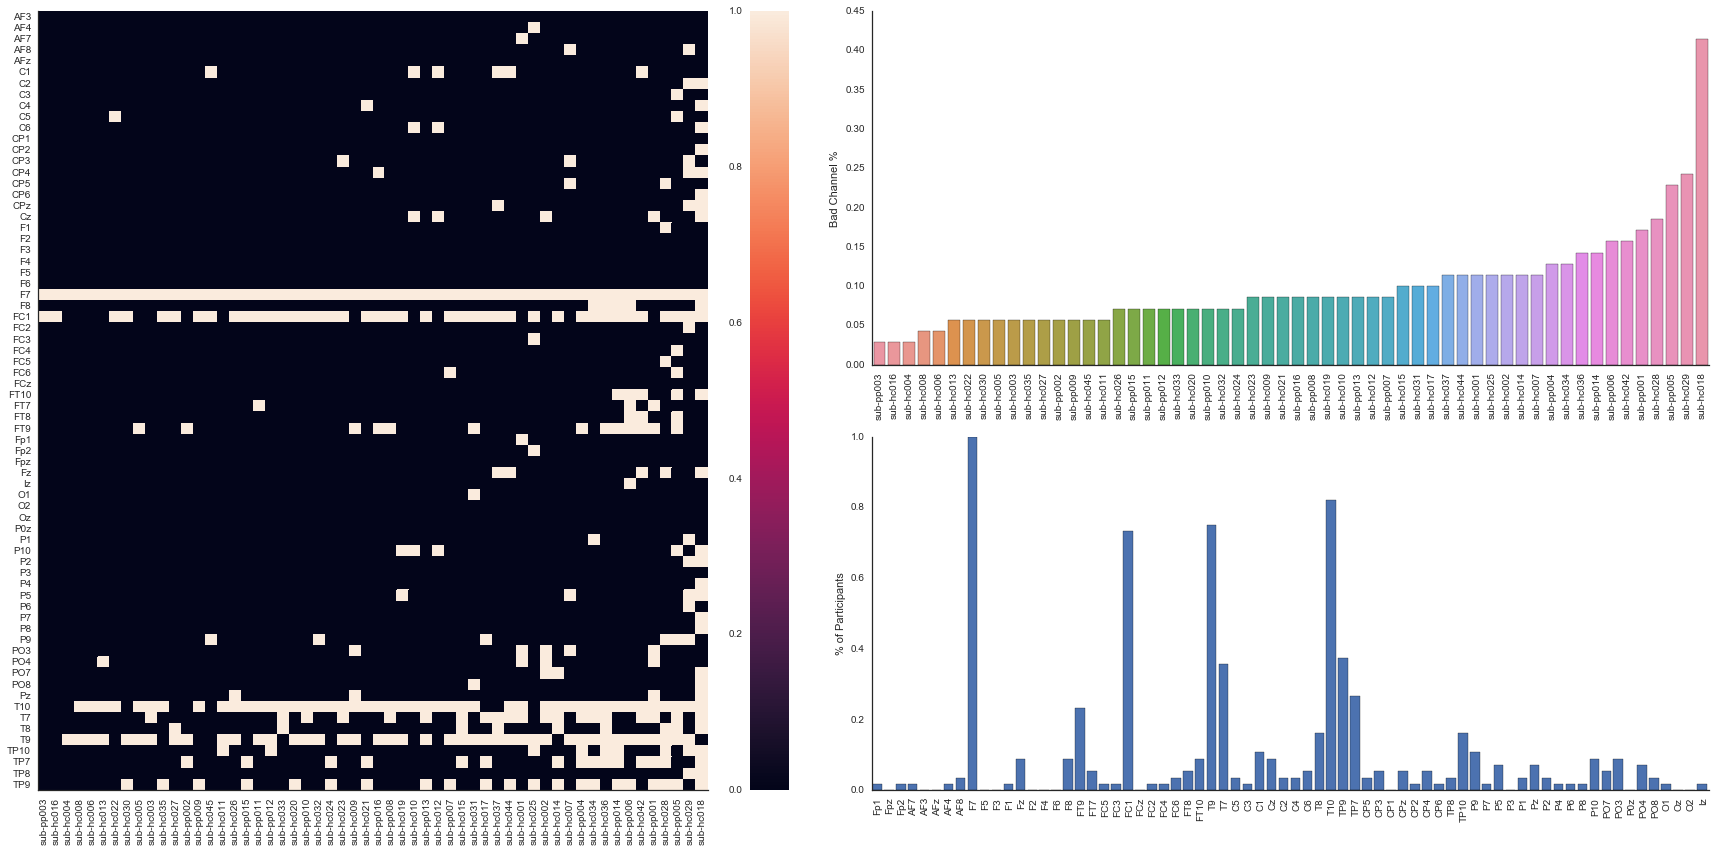

In [2]:
import sys
sys.path.append('../src')
from preprocessing import extract_bad_ch_group_info, plot_bad_chs_group_summary
from utils import CH_NAMES

%matplotlib inline

bad_ch_info = extract_bad_ch_group_info('../data/derivatives/eeg_preprocessing', CH_NAMES)
fig = plot_bad_chs_group_summary(bad_ch_info, CH_NAMES)
fig.savefig('../data/derivatives/eeg_preprocessing/bad_chs_summary.png')

## Bad Epochs Group Summary

This cell plots the number of bad epochs thrown out by autoreject for each subject to give us a sense of which subjects had the noisiest epochs (or hardest for autoreject to deal with at least).

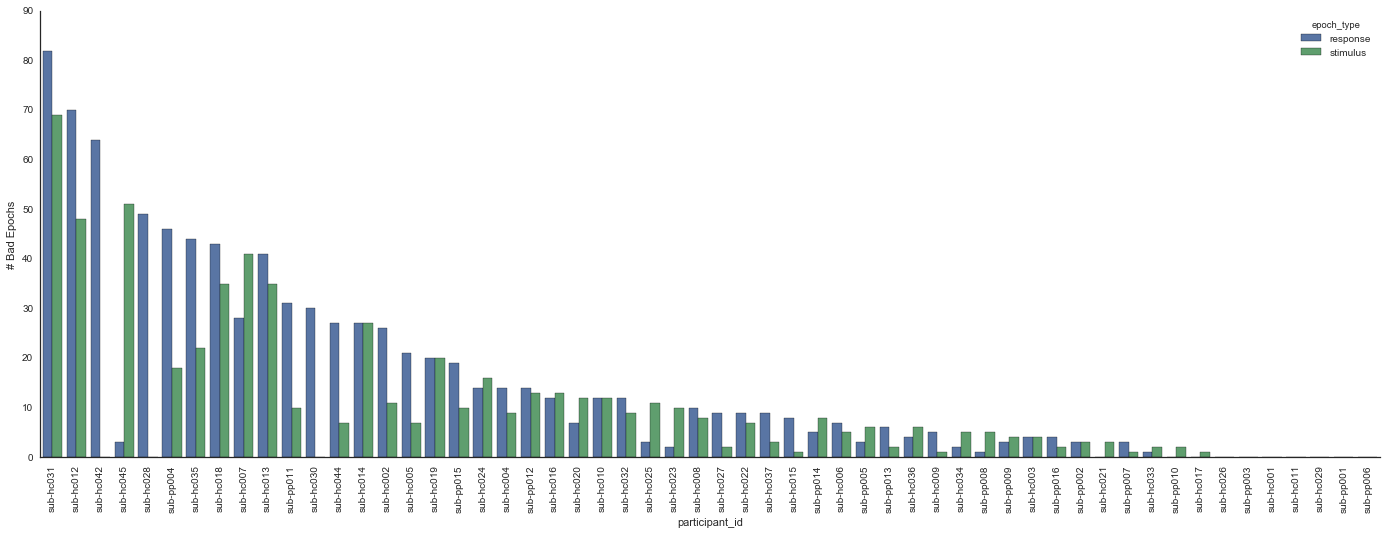

In [3]:
import sys
sys.path.append('../src')
from preprocessing import extract_bad_epochs_group_info
from utils import CH_NAMES
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white')

bad_epoch_info = extract_bad_epochs_group_info('../data/derivatives/eeg_preprocessing', 
                                               CH_NAMES)
plt.figure(figsize=(24, 8))
sns.barplot(x='participant_id', y='num_bad', hue='epoch_type', 
            data=bad_epoch_info.sort_values(by='num_bad', ascending=False))
plt.xticks(rotation=90)
plt.ylabel('# Bad Epochs')
sns.despine()
plt.savefig('../data/derivatives/eeg_preprocessing/bad_epochs_summary.png')

## Denote Subject Exlusions

To determine subjects for exclusion, I looked at subjects with the least number of epochs and good channels remaining using the visual summaries above. I then took subjects who stood out in these criteria and further dug into their summary plots to determine if their data was grounds for exclusion.

Despite several subjects having quite a lot of epochs thrown out by autoreject, when looking at the summary figures of the data, the data still looks fairly clean and has the same main shape after autoreject. This suggests that while there may have been a lot of noisy trials (or perhaps just a weird autoreject fit), the remaining data still provides a clean evoked. Because I didn't exclude any participants based on epochs count.

For the bad channels, sub-hc018 is clear grounds for exclusion. With nearly half the channels bad, both the average re-reference and surface laplacian are on invalid grounds. This is just too many bad channels to include. Despite the next few having nearly a quarter of channels bad, these still have fairly decent coverage (a lot of the bad channels are especially in the temporals) and the evoked data looks fairly reasonable. Because of this I didn't exclude any more participants based on bad channel count.

This is not to say that the rest of the subject's data is perfectly clean. Indeed, this was quite a noisy dataset. However, I want to be fairly conservative in throwing out data without a more objective criterion and so I only exclude sub-hc018 who was a clear outlier in channel count.

In [6]:
import sys
sys.path.append('../src')
from utils import exclude_subjects 

exclude_subjects(['sub-hc018'], 'eeg')